<b>Author:</b> ...

<b>Contributors:</b> ...


<div class="alert alert-block alert-info">
Before you start running this notebook, make sure you are using the Hail Genomics Analysis Environment. To do so,
<br/>
    
<ul>
    <li>Click on the <b>cloud analysis environment</b> icon on the righthand side of the screen.</li>
    <li>Inside <b>Recommended environments</b>, select <b>Hail Genomics Analysis</b> which creates a cloud environment for your analyses.</li>
    <li>This analysis can be run with <b>low compute</b> (e.g. 2 workers with 4 CPUs, 15 GB of RAM).</li>
    <li>Click on <b>Next</b>.</li>
</ul>
    
</div>

<h1>Notebook Objectives</h1>

This notebook shows where the BAM files and manifest are, how to localize the manifest or a known BAM to your workspace bucket and active environment, and how to use the manifest to localize BAMs by the included paths.

<b>How to Use this Notebook...</b>

<b>As a tutorial:</b>

...

<b>As a resource:</b>

...

<h2>Relevant Information:</h2>

...

In [1]:
try:
    import cartopy
except ImportError:
    print("Cartopy not found. Installing... (note, you will need to restart the Jupyter notebook kernel before proceeding).")
    !pip install cartopy

In [2]:
import cartopy

In [3]:
import pandas
import os

# This query represents dataset "Long reads, basic info, socioeconomic status" for domain "person" and was generated for All of Us Controlled Tier Dataset v7
dataset_08543380_person_sql = """
    SELECT
        person.person_id,
        person.gender_concept_id,
        p_gender_concept.concept_name as gender,
        person.birth_datetime as date_of_birth,
        person.race_concept_id,
        p_race_concept.concept_name as race,
        person.ethnicity_concept_id,
        p_ethnicity_concept.concept_name as ethnicity,
        person.sex_at_birth_concept_id,
        p_sex_at_birth_concept.concept_name as sex_at_birth 
    FROM
        `""" + os.environ["WORKSPACE_CDR"] + """.person` person 
    LEFT JOIN
        `""" + os.environ["WORKSPACE_CDR"] + """.concept` p_gender_concept 
            ON person.gender_concept_id = p_gender_concept.concept_id 
    LEFT JOIN
        `""" + os.environ["WORKSPACE_CDR"] + """.concept` p_race_concept 
            ON person.race_concept_id = p_race_concept.concept_id 
    LEFT JOIN
        `""" + os.environ["WORKSPACE_CDR"] + """.concept` p_ethnicity_concept 
            ON person.ethnicity_concept_id = p_ethnicity_concept.concept_id 
    LEFT JOIN
        `""" + os.environ["WORKSPACE_CDR"] + """.concept` p_sex_at_birth_concept 
            ON person.sex_at_birth_concept_id = p_sex_at_birth_concept.concept_id  
    WHERE
        person.PERSON_ID IN (SELECT
            distinct person_id  
        FROM
            `""" + os.environ["WORKSPACE_CDR"] + """.cb_search_person` cb_search_person  
        WHERE
            cb_search_person.person_id IN (SELECT
                person_id 
            FROM
                `""" + os.environ["WORKSPACE_CDR"] + """.cb_search_person` p 
            WHERE
                has_whole_genome_variant = 1 ) 
            AND cb_search_person.person_id IN (SELECT
                person_id 
            FROM
                `""" + os.environ["WORKSPACE_CDR"] + """.cb_search_person` p 
            WHERE
                has_lr_whole_genome_variant = 1 ) )"""

dataset_08543380_person_df = pandas.read_gbq(
    dataset_08543380_person_sql,
    dialect="standard",
    use_bqstorage_api=("BIGQUERY_STORAGE_API_ENABLED" in os.environ),
    progress_bar_type="tqdm_notebook")

dataset_08543380_person_df.head(5)

Downloading:   0%|          | 0/1027 [00:00<?, ?rows/s]

,person_id,gender_concept_id,gender,date_of_birth,race_concept_id,race,ethnicity_concept_id,ethnicity,sex_at_birth_concept_id,sex_at_birth
0,1904084,45878463,Female,1969-06-15 00:00:00+00:00,8516,Black or African American,38003564,Not Hispanic or Latino,46273637,Intersex
1,1938812,903096,PMI: Skip,2000-06-15 00:00:00+00:00,903096,PMI: Skip,903096,PMI: Skip,0,No matching concept
2,1617794,903096,PMI: Skip,1964-06-15 00:00:00+00:00,903096,PMI: Skip,903096,PMI: Skip,0,No matching concept
3,1222342,903096,PMI: Skip,1994-06-15 00:00:00+00:00,903096,PMI: Skip,903096,PMI: Skip,0,No matching concept
4,1649460,903096,PMI: Skip,1951-06-15 00:00:00+00:00,903096,PMI: Skip,903096,PMI: Skip,0,No matching concept


In [4]:
import pandas
import os

# This query represents dataset "Long reads, basic info, socioeconomic status" for domain "survey" and was generated for All of Us Controlled Tier Dataset v7
dataset_08543380_survey_sql = """
    SELECT
        answer.person_id,
        answer.survey_datetime,
        answer.survey,
        answer.question_concept_id,
        answer.question,
        answer.answer_concept_id,
        answer.answer,
        answer.survey_version_concept_id,
        answer.survey_version_name  
    FROM
        `""" + os.environ["WORKSPACE_CDR"] + """.ds_survey` answer   
    WHERE
        (
            question_concept_id IN (SELECT
                DISTINCT concept_id                         
            FROM
                `""" + os.environ["WORKSPACE_CDR"] + """.cb_criteria` c                         
            JOIN
                (SELECT
                    CAST(cr.id as string) AS id                               
                FROM
                    `""" + os.environ["WORKSPACE_CDR"] + """.cb_criteria` cr                               
                WHERE
                    concept_id IN (1586134)                               
                    AND domain_id = 'SURVEY') a 
                    ON (c.path like CONCAT('%', a.id, '.%'))                         
            WHERE
                domain_id = 'SURVEY'                         
                AND type = 'PPI'                         
                AND subtype = 'QUESTION')
        )  
        AND (
            answer.PERSON_ID IN (SELECT
                distinct person_id  
            FROM
                `""" + os.environ["WORKSPACE_CDR"] + """.cb_search_person` cb_search_person  
            WHERE
                cb_search_person.person_id IN (SELECT
                    person_id 
                FROM
                    `""" + os.environ["WORKSPACE_CDR"] + """.cb_search_person` p 
                WHERE
                    has_whole_genome_variant = 1 ) 
                AND cb_search_person.person_id IN (SELECT
                    person_id 
                FROM
                    `""" + os.environ["WORKSPACE_CDR"] + """.cb_search_person` p 
                WHERE
                    has_lr_whole_genome_variant = 1 ) )
        )"""

dataset_08543380_survey_df = pandas.read_gbq(
    dataset_08543380_survey_sql,
    dialect="standard",
    use_bqstorage_api=("BIGQUERY_STORAGE_API_ENABLED" in os.environ),
    progress_bar_type="tqdm_notebook")

dataset_08543380_survey_df.head(5)

Downloading:   0%|          | 0/23227 [00:00<?, ?rows/s]

,person_id,survey_datetime,survey,question_concept_id,question,answer_concept_id,answer,survey_version_concept_id,survey_version_name
0,2053214,2020-01-13 21:52:43+00:00,The Basics,903573,Disability: Deaf,903503,Deaf: No,<NA>,None
1,1557856,2020-02-23 00:40:44+00:00,The Basics,903573,Disability: Deaf,903503,Deaf: No,<NA>,None
2,1557026,2019-11-04 16:59:45+00:00,The Basics,903573,Disability: Deaf,903503,Deaf: No,<NA>,None
3,1919216,2020-01-21 09:19:33+00:00,The Basics,903573,Disability: Deaf,903503,Deaf: No,<NA>,None
4,1815792,2020-02-11 17:44:36+00:00,The Basics,903573,Disability: Deaf,903503,Deaf: No,<NA>,None


In [5]:
import pandas
import os

# This query represents dataset "Long reads, basic info, socioeconomic status" for domain "zip_code_socioeconomic" and was generated for All of Us Controlled Tier Dataset v7
dataset_08543380_zip_code_socioeconomic_sql = """
    SELECT
        observation.person_id,
        observation.observation_datetime,
        zip_code.zip3_as_string as zip_code,
        zip_code.fraction_assisted_income as assisted_income,
        zip_code.fraction_high_school_edu as high_school_education,
        zip_code.median_income,
        zip_code.fraction_no_health_ins as no_health_insurance,
        zip_code.fraction_poverty as poverty,
        zip_code.fraction_vacant_housing as vacant_housing,
        zip_code.deprivation_index,
        zip_code.acs as american_community_survey_year 
    FROM
        `""" + os.environ["WORKSPACE_CDR"] + """.zip3_ses_map` zip_code 
    JOIN
        `""" + os.environ["WORKSPACE_CDR"] + """.observation` observation 
            ON CAST(SUBSTR(observation.value_as_string, 0, STRPOS(observation.value_as_string, '*') - 1) AS INT64) = zip_code.zip3  
    WHERE
        observation.PERSON_ID IN (SELECT
            distinct person_id  
        FROM
            `""" + os.environ["WORKSPACE_CDR"] + """.cb_search_person` cb_search_person  
        WHERE
            cb_search_person.person_id IN (SELECT
                person_id 
            FROM
                `""" + os.environ["WORKSPACE_CDR"] + """.cb_search_person` p 
            WHERE
                has_whole_genome_variant = 1 ) 
            AND cb_search_person.person_id IN (SELECT
                person_id 
            FROM
                `""" + os.environ["WORKSPACE_CDR"] + """.cb_search_person` p 
            WHERE
                has_lr_whole_genome_variant = 1 ) ) 
        AND observation_source_concept_id = 1585250 
        AND observation.value_as_string NOT LIKE 'Res%'"""

dataset_08543380_zip_code_socioeconomic_df = pandas.read_gbq(
    dataset_08543380_zip_code_socioeconomic_sql,
    dialect="standard",
    use_bqstorage_api=("BIGQUERY_STORAGE_API_ENABLED" in os.environ),
    progress_bar_type="tqdm_notebook")

dataset_08543380_zip_code_socioeconomic_df.head(5)

Downloading:   0%|          | 0/1027 [00:00<?, ?rows/s]

,person_id,observation_datetime,zip_code,assisted_income,high_school_education,median_income,no_health_insurance,poverty,vacant_housing,deprivation_index,american_community_survey_year
0,1063400,2019-10-17 15:50:01+00:00,112**,25.330880,80.149569,57306.992449,9.536435,21.878357,7.951113,0.389791,2017
1,1359383,2020-02-03 17:48:45+00:00,352**,15.225864,90.811209,61024.188411,10.300264,18.208478,13.866312,0.332554,2017
2,1305974,2020-02-25 00:52:54+00:00,958**,17.057142,83.889684,56263.624672,9.410737,20.408753,6.198068,0.354028,2017
3,1426430,2019-10-29 18:54:41+00:00,482**,37.188040,81.186586,36325.851256,11.406904,33.712774,23.329607,0.490607,2017
4,1015507,2020-01-16 23:16:24+00:00,903**,15.485637,69.353518,47409.163408,18.164104,21.417496,4.457222,0.428581,2017


In [6]:
dataset_08543380_zip_code_socioeconomic_df.zip_code

0       112**
1       352**
2       958**
3       482**
4       903**
        ...  
1022    152**
1023    303**
1024    104**
1025    352**
1026    366**
Name: zip_code, Length: 1027, dtype: object

In [7]:
import pandas
import os

# This query represents dataset "All participants, basic info, socioeconomic status" for domain "survey" and was generated for All of Us Controlled Tier Dataset v7
dataset_45551076_survey_sql = """
    SELECT
        answer.person_id,
        answer.survey_datetime,
        answer.survey,
        answer.question_concept_id,
        answer.question,
        answer.answer_concept_id,
        answer.answer,
        answer.survey_version_concept_id,
        answer.survey_version_name  
    FROM
        `""" + os.environ["WORKSPACE_CDR"] + """.ds_survey` answer   
    WHERE
        (
            question_concept_id IN (SELECT
                DISTINCT concept_id                         
            FROM
                `""" + os.environ["WORKSPACE_CDR"] + """.cb_criteria` c                         
            JOIN
                (SELECT
                    CAST(cr.id as string) AS id                               
                FROM
                    `""" + os.environ["WORKSPACE_CDR"] + """.cb_criteria` cr                               
                WHERE
                    concept_id IN (1586134)                               
                    AND domain_id = 'SURVEY') a 
                    ON (c.path like CONCAT('%', a.id, '.%'))                         
            WHERE
                domain_id = 'SURVEY'                         
                AND type = 'PPI'                         
                AND subtype = 'QUESTION')
        )"""

dataset_45551076_survey_df = pandas.read_gbq(
    dataset_45551076_survey_sql,
    dialect="standard",
    use_bqstorage_api=("BIGQUERY_STORAGE_API_ENABLED" in os.environ),
    progress_bar_type="tqdm_notebook")

dataset_45551076_survey_df.head(5)

Downloading:   0%|          | 0/8506271 [00:00<?, ?rows/s]

,person_id,survey_datetime,survey,question_concept_id,question,answer_concept_id,answer,survey_version_concept_id,survey_version_name
0,5019160,2021-09-10 13:03:41+00:00,The Basics,903573,Disability: Deaf,903503,Deaf: No,<NA>,None
1,1440968,2020-02-19 16:58:40+00:00,The Basics,903573,Disability: Deaf,903503,Deaf: No,<NA>,None
2,1066140,2019-11-20 15:34:48+00:00,The Basics,903573,Disability: Deaf,903503,Deaf: No,<NA>,None
3,6713991,2021-12-04 02:11:23+00:00,The Basics,903573,Disability: Deaf,903503,Deaf: No,<NA>,None
4,1712276,2019-11-08 17:52:51+00:00,The Basics,903573,Disability: Deaf,903503,Deaf: No,<NA>,None


In [8]:
import pandas
import os

# This query represents dataset "All participants, basic info, socioeconomic status" for domain "zip_code_socioeconomic" and was generated for All of Us Controlled Tier Dataset v7
dataset_45551076_zip_code_socioeconomic_sql = """
    SELECT
        observation.person_id,
        observation.observation_datetime,
        zip_code.zip3_as_string as zip_code,
        zip_code.fraction_assisted_income as assisted_income,
        zip_code.fraction_high_school_edu as high_school_education,
        zip_code.median_income,
        zip_code.fraction_no_health_ins as no_health_insurance,
        zip_code.fraction_poverty as poverty,
        zip_code.fraction_vacant_housing as vacant_housing,
        zip_code.deprivation_index,
        zip_code.acs as american_community_survey_year 
    FROM
        `""" + os.environ["WORKSPACE_CDR"] + """.zip3_ses_map` zip_code 
    JOIN
        `""" + os.environ["WORKSPACE_CDR"] + """.observation` observation 
            ON CAST(SUBSTR(observation.value_as_string, 0, STRPOS(observation.value_as_string, '*') - 1) AS INT64) = zip_code.zip3 
            AND observation_source_concept_id = 1585250 
            AND observation.value_as_string NOT LIKE 'Res%'"""

dataset_45551076_zip_code_socioeconomic_df = pandas.read_gbq(
    dataset_45551076_zip_code_socioeconomic_sql,
    dialect="standard",
    use_bqstorage_api=("BIGQUERY_STORAGE_API_ENABLED" in os.environ),
    progress_bar_type="tqdm_notebook")

dataset_45551076_zip_code_socioeconomic_df.head(5)

Downloading:   0%|          | 0/413174 [00:00<?, ?rows/s]

,person_id,observation_datetime,zip_code,assisted_income,high_school_education,median_income,no_health_insurance,poverty,vacant_housing,deprivation_index,american_community_survey_year
0,1629353,2020-03-05 17:08:33+00:00,014**,12.575548,89.827996,76472.899608,2.848565,10.800381,7.986200,0.263013,2017
1,2364725,2019-06-19 15:36:44+00:00,016**,22.527143,84.993562,50685.199639,3.221594,21.453950,9.305993,0.355175,2017
2,3071370,2019-03-05 16:16:57+00:00,016**,22.527143,84.993562,50685.199639,3.221594,21.453950,9.305993,0.355175,2017
3,1601612,2018-06-26 17:07:44+00:00,018**,13.638782,88.950838,88796.704011,2.961726,10.277005,4.678395,0.251301,2017
4,6740601,2022-05-26 20:06:37+00:00,018**,13.638782,88.950838,88796.704011,2.961726,10.277005,4.678395,0.251301,2017


In [9]:
!wget -O US.zip https://download.geonames.org/export/zip/US.zip

--2025-09-24 16:16:33--  https://download.geonames.org/export/zip/US.zip
Resolving download.geonames.org (download.geonames.org)... 5.9.152.54
Connecting to download.geonames.org (download.geonames.org)|5.9.152.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 634319 (619K) [application/zip]
Saving to: ‘US.zip’

US.zip              100%[===================>] 619.45K   998KB/s    in 0.6s    

2025-09-24 16:16:34 (998 KB/s) - ‘US.zip’ saved [634319/634319]



In [13]:
!unzip -o US.zip

Archive:  US.zip
  inflating: readme.txt              
  inflating: US.txt                  


In [14]:
!ls

00_README.ipynb
01_Getting_started.ipynb
01_Short_Read_Genotyping_Imputation.ipynb
Age_Distribution_by_Sex_20plus.pdf
Age_Distribution_by_Sex_20plus.png
Age_Distribution_by_Sex.pdf
Age_Distribution_by_Sex.png
AoU_condition_with_details.csv
AoU_LR_samples_all_domains.csv
AoU_LR_samples_all_domains_with_sex.csv
auxiliary_metrics.GRCh38.tsv
CONCEPT_ANCESTOR.csv
CONCEPT_CLASS.csv
CONCEPT.csv
concept_hierarchy_mapping.tsv
CONCEPT_RELATIONSHIP.csv
CONCEPT_SYNONYM.csv
coverage_metrics_boxplot.pdf
disease_summary_suptable.csv
DOMAIN.csv
DRUG_STRENGTH.csv
Enriched_diseases.pdf
Enriched_diseases.png
full_report_map.txt
genomic_metrics.tsv
gwas1.csv
highlighted_zip_codes_map.pdf
init_subset_vds.ipynb
JW_CYP2D6.ipynb
JW_repeat_expansion_figures.ipynb
kvg_firth_logistic_regression.ipynb
kvg_locityper_genotyping_v2.csv.gz
kvg_pmi_skip_participants.ipynb
lr_sample_ids.txt
main_figure_01_length_distributions.ipynb
main_figure_01_map.ipynb
main_figure_01_omop.ipynb
main_figure_01_pca.ipynb
main_table_0

In [15]:
!head US.txt

US	99553	Akutan	Alaska	AK	Aleutians East	013			54.143	-165.7854	1
US	99571	Cold Bay	Alaska	AK	Aleutians East	013			55.1858	-162.7211	1
US	99583	False Pass	Alaska	AK	Aleutians East	013			54.8542	-163.4113	1
US	99612	King Cove	Alaska	AK	Aleutians East	013			55.0628	-162.3056	1
US	99661	Sand Point	Alaska	AK	Aleutians East	013			55.3192	-160.4914	1
US	99546	Adak	Alaska	AK	Aleutians West (CA)	016			51.874	-176.634	1
US	99547	Atka	Alaska	AK	Aleutians West (CA)	016			52.1961	-174.2006	1
US	99591	Saint George Island	Alaska	AK	Aleutians West (CA)	016			56.5944	-169.6186	1
US	99638	Nikolski	Alaska	AK	Aleutians West (CA)	016			52.9381	-168.8678	1
US	99660	Saint Paul Island	Alaska	AK	Aleutians West (CA)	016			57.1842	-170.2764	1


In [16]:
import pandas as pd

columns = [
    'country code', 'postal code', 'place name', 'admin name1', 'admin code1', 
    'admin name2', 'admin code2', 'admin name3', 'admin code3', 
    'latitude', 'longitude', 'accuracy'
]

# Read the file into a Pandas DataFrame
df = pd.read_csv('US.txt', sep='\t', header=None, names=columns)

In [17]:
df

,country code,postal code,place name,admin name1,admin code1,admin name2,admin code2,admin name3,admin code3,latitude,longitude,accuracy
0,US,99553,Akutan,Alaska,AK,Aleutians East,13.0,NaN,NaN,54.1430,-165.7854,1.0
1,US,99571,Cold Bay,Alaska,AK,Aleutians East,13.0,NaN,NaN,55.1858,-162.7211,1.0
2,US,99583,False Pass,Alaska,AK,Aleutians East,13.0,NaN,NaN,54.8542,-163.4113,1.0
3,US,99612,King Cove,Alaska,AK,Aleutians East,13.0,NaN,NaN,55.0628,-162.3056,1.0
4,US,99661,Sand Point,Alaska,AK,Aleutians East,13.0,NaN,NaN,55.3192,-160.4914,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
41484,US,96558,APO AA,NaN,NaN,NaN,NaN,NaN,NaN,19.7542,-155.5858,4.0
41485,US,96598,FPO AA,NaN,NaN,NaN,NaN,NaN,NaN,-89.9976,139.2729,NaN
41486,US,96599,FPO AA,NaN,NaN,NaN,NaN,NaN,NaN,-77.8460,166.6760,NaN
41487,US,96860,FPO AA,NaN,NaN,NaN,NaN,NaN,NaN,21.3448,-157.9774,4.0


In [18]:
df['postal code'] = df['postal code'].astype(str)

# Trim the postal code to the first three digits
df['postal code'] = df['postal code'].str[:3]

# Group by the modified postal code and take one row from each group
df_grouped = df.groupby('postal code').first().reset_index()

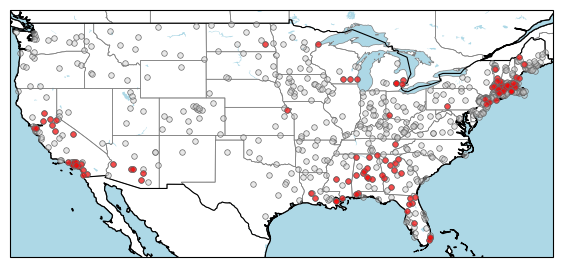

In [19]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Extract unique 3-digit ZIP codes from the DataFrame
all_zip3 = dataset_45551076_zip_code_socioeconomic_df['zip_code'].str[:3].unique()
highlight_zip3 = dataset_08543380_zip_code_socioeconomic_df['zip_code'].str[:3].unique()

# Example centroids or approximate locations for 3-digit ZIP codes
zip3_locations = df_grouped.set_index('postal code')[['longitude', 'latitude']].apply(tuple, axis=1).to_dict()

# Filter locations to include only the ZIPs in your DataFrame
all_filtered_locations = {zip3: coords for zip3, coords in zip3_locations.items() if zip3 in all_zip3}
highlight_filtered_locations = {zip3: coords for zip3, coords in zip3_locations.items() if zip3 in highlight_zip3}

# Create the map
fig, ax = plt.subplots(figsize=(7, 7), subplot_kw={'projection': ccrs.PlateCarree()})
#ax.set_extent([-128, -65, 20, 49])  # Continental US bounds
ax.set_extent([-125, -67, 24, 47])  # Continental US bounds

# Add state boundaries and coastlines
#ax.add_feature(cfeature.LAND, edgecolor='black', zorder=0, facecolor='white')  # Add land background
ax.add_feature(cfeature.LAND, edgecolor='black', zorder=0, facecolor='white')  # Add land background
ax.add_feature(cfeature.OCEAN, facecolor='lightblue', zorder=0)  # Add ocean background
ax.add_feature(cfeature.STATES, edgecolor='grey', linewidth=0.5, zorder=1)  # Add state boundaries
ax.add_feature(cfeature.COASTLINE, edgecolor='black', linewidth=0.8, zorder=1)  # Add coastlines
ax.add_feature(cfeature.BORDERS, edgecolor='black', linewidth=0.8, zorder=1)  # Add country borders
ax.add_feature(cfeature.LAKES, facecolor='lightblue', zorder=0)
#ax.add_feature(cfeature.RIVERS, facecolor='lightblue', zorder=0)

# Highlight ZIP code regions
for zip3, (lon, lat) in all_filtered_locations.items():
    ax.plot(lon, lat, 'o', color='#cccccc77', markeredgecolor='dimgray', markeredgewidth=0.5, markersize=4, label=f"ZIP {zip3}")  # Red dots for ZIP code locations
    
for zip3, (lon, lat) in highlight_filtered_locations.items():
    ax.plot(lon, lat, 'o', color='#ff0000aa', markeredgecolor='dimgray', markeredgewidth=0.5, markersize=4, label=f"ZIP {zip3}")  # Red dots for ZIP code locations

# Save the map as a PDF
plt.savefig("highlighted_zip_codes_map.pdf", format="pdf", bbox_inches="tight")
    
# Show the map
plt.show()

In [46]:
!gsutil cp highlighted_zip_codes_map.pdf $WORKSPACE_BUCKET/scratch/kvg/

Copying file://highlighted_zip_codes_map.pdf [Content-Type=application/pdf]...
- [1 files][ 1001 KiB/ 1001 KiB]                                                
Operation completed over 1 objects/1001.2 KiB.                                   


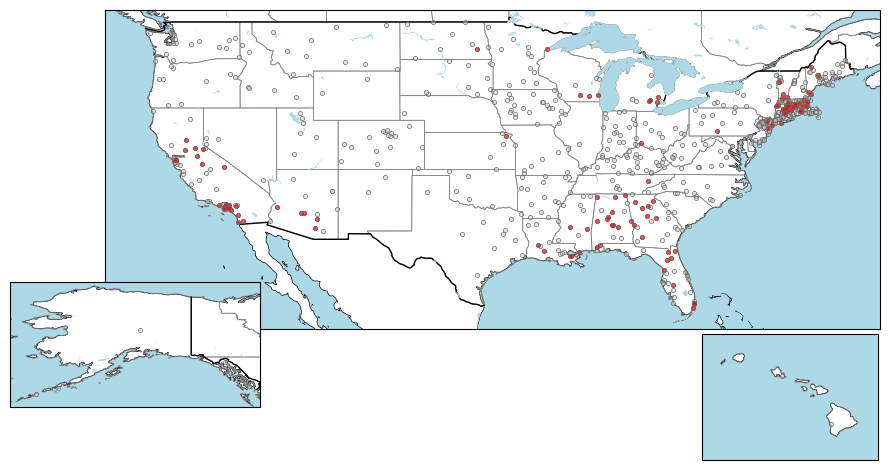

In [88]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Create main figure and axis
fig = plt.figure(figsize=(10, 7))
main_ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
main_ax.set_extent([-128, -65, 24, 50], crs=ccrs.PlateCarree())  # Mainland US

# Base map features
for ax in [main_ax]:
    ax.add_feature(cfeature.LAND, facecolor='white', edgecolor='black')
    ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
    ax.add_feature(cfeature.STATES, edgecolor='gray', linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, edgecolor='black')
    ax.add_feature(cfeature.LAKES, facecolor='lightblue')

# -- Add Alaska inset --
ax_ak = fig.add_axes([0.03, 0.12, 0.25, 0.25], projection=ccrs.PlateCarree())  # [left, bottom, width, height]
ax_ak.set_extent([-170, -130, 52, 72], crs=ccrs.PlateCarree())
ax_ak.add_feature(cfeature.LAND, facecolor='white', edgecolor='black')
ax_ak.add_feature(cfeature.OCEAN, facecolor='lightblue')
ax_ak.add_feature(cfeature.STATES, edgecolor='gray', linewidth=0.5)
ax_ak.add_feature(cfeature.BORDERS, edgecolor='black')
ax_ak.add_feature(cfeature.LAKES, facecolor='lightblue')

# -- Add Hawaii inset --
ax_hi = fig.add_axes([0.72, 0.08, 0.18, 0.18], projection=ccrs.PlateCarree())
ax_hi.set_extent([-161, -154, 18, 23], crs=ccrs.PlateCarree())
ax_hi.add_feature(cfeature.LAND, facecolor='white', edgecolor='black')
ax_hi.add_feature(cfeature.OCEAN, facecolor='lightblue')
ax_hi.add_feature(cfeature.STATES, edgecolor='gray', linewidth=0.5)
ax_hi.add_feature(cfeature.BORDERS, edgecolor='black')
ax_hi.add_feature(cfeature.LAKES, facecolor='lightblue')

# -- Plot points for each region --
def plot_points(ax, points_dict, color):
    for zip3, (lon, lat) in points_dict.items():
        ax.plot(lon, lat, 'o', color=color, markersize=3, markeredgecolor='dimgray', markeredgewidth=0.5)

# Plot all points
plot_points(main_ax, all_filtered_locations, '#cccccc77')
plot_points(main_ax, highlight_filtered_locations, '#ff0000aa')

plot_points(ax_ak, all_filtered_locations, '#cccccc77')
plot_points(ax_ak, highlight_filtered_locations, '#ff0000aa')

plot_points(ax_hi, all_filtered_locations, '#cccccc77')
plot_points(ax_hi, highlight_filtered_locations, '#ff0000aa')

# Save or show
plt.savefig("highlighted_zip_codes_map.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [21]:
dataset_08543380_zip_code_socioeconomic_df

,person_id,observation_datetime,zip_code,assisted_income,high_school_education,median_income,no_health_insurance,poverty,vacant_housing,deprivation_index,american_community_survey_year
0,1063400,2019-10-17 15:50:01+00:00,112**,25.330880,80.149569,57306.992449,9.536435,21.878357,7.951113,0.389791,2017
1,1359383,2020-02-03 17:48:45+00:00,352**,15.225864,90.811209,61024.188411,10.300264,18.208478,13.866312,0.332554,2017
2,1305974,2020-02-25 00:52:54+00:00,958**,17.057142,83.889684,56263.624672,9.410737,20.408753,6.198068,0.354028,2017
3,1426430,2019-10-29 18:54:41+00:00,482**,37.188040,81.186586,36325.851256,11.406904,33.712774,23.329607,0.490607,2017
4,1015507,2020-01-16 23:16:24+00:00,903**,15.485637,69.353518,47409.163408,18.164104,21.417496,4.457222,0.428581,2017
...,...,...,...,...,...,...,...,...,...,...,...
1022,1706061,2019-11-19 19:56:51+00:00,152**,13.313458,93.789391,60080.505422,5.502843,14.925582,10.289364,0.291886,2017
1023,1242194,2020-01-17 00:14:04+00:00,303**,14.651095,89.479719,64686.534919,14.353899,18.930404,14.704588,0.347788,2017
1024,1032684,2019-11-18 21:30:20+00:00,104**,38.279736,70.896923,39407.415829,11.049983,29.653439,5.505385,0.485979,2017
1025,1803959,2019-12-05 19:05:32+00:00,352**,15.225864,90.811209,61024.188411,10.300264,18.208478,13.866312,0.332554,2017


In [26]:
!pip install pgeocode uszipcode

  Preparing metadata (setup.py) ... done
  DEPRECATION: Building 'atomicwrites' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'atomicwrites'. Discussion can be found at https://github.com/pypa/pip/issues/6334
  Created wheel for atomicwrites: filename=atomicwrites-1.4.1-py2.py3-none-any.whl size=6942 sha256=8a217bb05d92744b607f081d43353e2b0473f090f9fd63dfc12bed7578883e15
  Stored in directory: /home/jupyter/.cache/pip/wheels/34/07/0b/33b15f68736109f72ea0bb2499521d87312b932620737447a2
Successfully built atomicwrites
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6/6 [uszipcode]/6 [sqlalchemy-mate]

[notice] A new release of pip is available: 25.1 -> 25.2
[notice] To update, run: pip install --up

In [35]:
import pandas as pd
import pgeocode

# --- Your Phase 1 dataframe ---
df = dataset_08543380_zip_code_socioeconomic_df.copy()

# Extract ZIP3 from masked ZIP codes (e.g. '112**' -> '112')
df["zip3"] = df["zip_code"].astype(str).str.extract(r"(\d{3})")

# --- Build ZIP3 -> state crosswalk vectorized ---
nomi = pgeocode.Nominatim("us")
all_zip5 = nomi._data[["postal_code", "state_code"]].dropna().copy()
all_zip5["zip5"] = all_zip5["postal_code"].astype(str).str.zfill(5)
all_zip5["zip3"] = all_zip5["zip5"].str[:3]

zip3_to_state = (
    all_zip5.groupby("zip3")["state_code"]
            .agg(lambda s: s.mode().iat[0])   # modal state per prefix
            .to_dict()
)

# --- Map ZIP3 to state in your data ---
df["state"] = df["zip3"].map(zip3_to_state)

# --- Count participants by state ---
state_counts = df.groupby("state").size().reset_index(name="count")
state_counts

,state,count
0,AL,187
1,AZ,40
2,CA,78
3,CT,11
4,FL,44
5,GA,96
6,IL,119
7,KS,1
8,LA,26
9,MA,91


/tmp/ipykernel_231/2991303620.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap("Greens", len(labels))


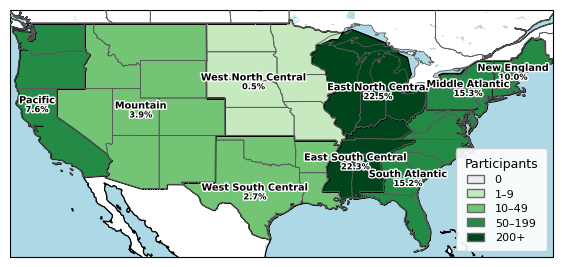

In [68]:
# ----------------------------
# 4) Plot — discrete buckets (Greens), crisp borders, labeled divisions
# ----------------------------

import matplotlib.patches as mpatches

# Choose bucket edges & labels (edit to taste)
bins   = [-0.1, 0, 9, 49, 199, 9999]     # 0, 1–9, 10–49, 50–199, 200+
labels = ["0", "1–9", "10–49", "50–199", "200+"]

# Discrete colormap with as many shades as buckets
cmap = mpl.cm.get_cmap("Greens", len(labels))

# Helper: find the bin index for a value
def bin_index(v):
    for i in range(len(bins) - 1):
        if bins[i] < v <= bins[i + 1]:
            return i
    return len(labels) - 1  # fallback to last bucket

# Map each division to a facecolor from the discrete palette
div_to_color = {}
for dv in division_geoms:
    cnt = division_to_count.get(dv, 0)
    if cnt <= 0:
        div_to_color[dv] = (0.93, 0.93, 0.93, 1.0)  # light grey for zero
    else:
        div_to_color[dv] = cmap(bin_index(cnt))

fig, ax = plt.subplots(figsize=(7, 7), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([-125, -67, 24, 47])  # CONUS

# Base layers
ax.add_feature(cfeature.LAND,    edgecolor='black', zorder=0, facecolor='white')
ax.add_feature(cfeature.OCEAN,   facecolor='lightblue', zorder=0)
ax.add_feature(cfeature.COASTLINE, edgecolor='black', linewidth=0.8, zorder=1)
ax.add_feature(cfeature.BORDERS,   edgecolor='black', linewidth=0.8, zorder=1)
ax.add_feature(cfeature.LAKES,     facecolor='lightblue', zorder=0)

# Draw divisions with discrete face colors
for dv, geom in division_geoms.items():
    if geom is None:
        continue
    ax.add_geometries([geom], ccrs.PlateCarree(),
                      facecolor=div_to_color.get(dv, (0.93, 0.93, 0.93, 1.0)),
                      edgecolor='black', linewidth=0.8, zorder=2)

# Overlay **crisper** state borders
ax.add_feature(cfeature.STATES, edgecolor="0.35", facecolor="none", linewidth=0.6, zorder=3)

# --- percentages per division ---
total_div = sum(division_to_count.values()) or 1  # avoid div-by-zero
div_to_pct = {dv: (division_to_count.get(dv, 0) / total_div) * 100.0
              for dv in division_geoms}

# Optional manual nudges to reduce overlap (tweak as needed)
offsets = {
    "West North Central": (-1.5,  0.5),
    "East North Central": ( 1.0, -0.5),
    "Middle Atlantic":    ( 1.0,  0.5),
}

# Label divisions + percentage beneath
for dv, geom in division_geoms.items():
    if geom is None:
        continue
    x, y = list(geom.representative_point().coords)[0]
    dx, dy = offsets.get(dv, (0, 0))

    # Division name
    ax.text(x+dx, y+dy, dv,
            transform=ccrs.PlateCarree(),
            ha="center", va="center",
            fontsize=7, fontweight="bold", color="black",
            path_effects=[pe.withStroke(linewidth=2, foreground="white")],
            zorder=4)

    # Percentage on a second line just below (slightly smaller)
    ax.text(x+dx, y+dy-1.0, f"{div_to_pct.get(dv, 0):.1f}%",
            transform=ccrs.PlateCarree(),
            ha="center", va="center",
            fontsize=6, fontweight="bold", color="black",
            path_effects=[pe.withStroke(linewidth=2, foreground="white")],
            zorder=4)

# Build legend handles: one for "0", the rest for bins >0
handles = []
handles.append(mpatches.Patch(facecolor=(0.93, 0.93, 0.93, 1.0),
                              edgecolor='dimgray', label="0"))

# Only add patches for >0 bins
for i, lab in enumerate(labels[1:], start=1):
    handles.append(mpatches.Patch(facecolor=cmap(i), edgecolor='dimgray', label=lab))

leg = ax.legend(
    handles=handles,
    title="Participants",
    loc="lower right",
    frameon=True,
    framealpha=0.9,
    fontsize=8,
    title_fontsize=9,
    handlelength=1.5,  # shorter color patches
    handletextpad=1.0, # tighter gap between patch and text
    borderpad=0.8,     # less empty space inside legend box
    labelspacing=0.4,  # tighter vertical spacing
)
for text in leg.get_texts():
    text.set_horizontalalignment("left")

# Save
plt.savefig("phase1_division_choropleth_buckets.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [69]:
!gsutil cp phase1_division_choropleth_buckets.pdf $WORKSPACE_BUCKET/scratch/kvg/

Copying file://phase1_division_choropleth_buckets.pdf [Content-Type=application/pdf]...
- [1 files][961.5 KiB/961.5 KiB]                                                
Operation completed over 1 objects/961.5 KiB.                                    
